# Calculating cyclone density

Import all the necessary libraries

In [1]:
%matplotlib inline
from functools import partial
from pathlib import Path

from octant import RUNTIME
from octant.core import TrackRun
from octant.misc import check_by_mask

RUNTIME.enable_progress_bar = True

Define the common data directory

In [2]:
sample_dir = Path('.') / 'sample_data'

Data are usually organised in hierarchical directory structure. Here, the relevant parameters are defined.

In [3]:
dataset = 'era5'
period = 'test'
run_id = 0

Construct the full path

In [4]:
track_res_dir = sample_dir / dataset / f'run{run_id:03d}' / period

## Load the data

Load land-sea mask array from ERA5 dataset:

In [5]:
import xarray as xr

In [6]:
lsm = xr.open_dataarray(sample_dir / dataset / 'lsm.nc')
lsm = lsm.squeeze()  # remove singular time dimension

Now load the cyclone tracks themselves

In [7]:
tr = TrackRun(track_res_dir)

### Classify the tracks

In [8]:
c = [
    ('aa', [lambda ot: ot.lifetime_h >= 6, partial(check_by_mask, trackrun=tr, lsm=lsm, rad=50.)]),
    ('bb', [lambda ot: (ot.vortex_type != 0).sum() / ot.shape[0] < 0.2,
            lambda ot: ot.gen_lys_dist_km > 300.0]),    
]

In [9]:
tr.classify(c, True)

In [10]:
tr.rename_cats(**{'aa': 'cat1', 'bb': 'cat2'})

In [11]:
tr

<octant.core.TrackRun> [671 tracks]

## Calculate density

In [12]:
import numpy as np

First, arrays of longitude and latitude are needed to define the grid.

In [13]:
lon_dens1d = np.arange(-20., 50.1, 1)
lat_dens1d = np.arange(65., 85.1, 1)
lon_dens, lat_dens = np.meshgrid(lon_dens1d, lat_dens1d)

In [14]:
dens = tr.density(lon_dens, lat_dens, method='cell')

In [15]:
dens

{'unknown': <xarray.DataArray 'point_density' (latitude: 21, longitude: 71)>
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [45.,  8., 34., ...,  0.,  0.,  0.],
        [10.,  7.,  5., ..., 10.,  0.,  0.],
        ...,
        [ 5.,  1.,  0., ...,  3.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
 Coordinates:
   * longitude  (longitude) float64 -20.0 -19.0 -18.0 -17.0 ... 48.0 49.0 50.0
   * latitude   (latitude) float64 65.0 66.0 67.0 68.0 ... 82.0 83.0 84.0 85.0
 Attributes:
     units:    1
     subset:   unknown
     method:   cell,
 'cat1': <xarray.DataArray 'point_density' (latitude: 21, longitude: 71)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
 Coordinates:
   * longitude  (longitude) float64 -20.0 -19.0 -18.0 -17

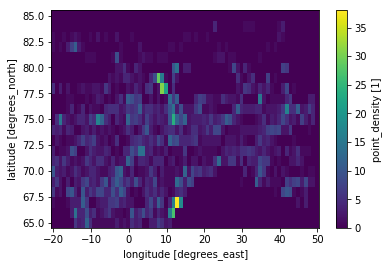

In [16]:
dens['cat1'].plot()